In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from botorch.models.gp_regression import (
    SingleTaskGP,
)
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.models.transforms.outcome import Standardize

from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.transforms import normalize, unnormalize
import os
import gc
from botorch.utils.sampling import draw_sobol_samples

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")
# SMOKE_TEST = True
print("SMOKE_TEST", SMOKE_TEST)
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
MC_SAMPLES = 128 if not SMOKE_TEST else 16
batch_size = 1


from run_experiment import initialize_model, generate_initial_data, optimize_acqf_loop

SMOKE_TEST None


In [9]:
from src.schwefel import SchwefelProblem
from time import time

torch.manual_seed(0)
np.random.seed(0)

problem = SchwefelProblem(n_var=2, noise_level=10)


seed = 0 
n_inits = 10
noise_level = 5
noise_bool = True

n_init = 50
budget = 1


torch.manual_seed(seed)
np.random.seed(seed)

problem = SchwefelProblem(n_var=2, noise_level=noise_level)

bounds = torch.tensor(problem.bounds, **tkwargs)

train_X, train_Y, train_Y_real= generate_initial_data(problem, n_init, bounds)

start_time = time()

for i in range(budget):
    print(f"Starting iteration {i}, total time: {time() - start_time:.3f} seconds.")
    
    train_x = normalize(train_X, bounds)
    mll, model = initialize_model(train_x, train_Y, noise_bool)
    fit_gpytorch_model(mll)
    
    # optimize the acquisition function and get the observations
    X_baseline = train_x
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    acq_func = qNoisyExpectedImprovement(
        model=model,
        X_baseline=X_baseline,
        prune_baseline=True,
        sampler=sampler,
    )

    x_cand, acq_func_val = optimize_acqf_loop(problem, acq_func)
    X_cand = unnormalize(x_cand, bounds)
    Y_cand = torch.tensor(problem.y(X_cand.numpy()))
    Y_cand_real = torch.tensor(problem.f(X_cand.numpy()))
    print(f"New candidate: {X_cand}, {Y_cand}")

    # update the model with new observations
    train_X = torch.cat([train_X, X_cand], dim=0)
    train_Y = torch.cat([train_Y, Y_cand], dim=0)
    train_Y_real = torch.cat([train_Y_real, Y_cand_real], dim=0)        
    
train_x = normalize(train_X, bounds)
mll, model = initialize_model(train_x, train_Y, noise_bool)
fit_gpytorch_model(mll)


Starting iteration 0, total time: 0.000 seconds.
New candidate: tensor([[-26.2945,  50.0000]], dtype=torch.float64), tensor([773.9874], dtype=torch.float64)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

Best value found: 773.9874075531119
Best solution found: [-26.29448786  50.        ]
Best real value found: 778.4647403590802
Best real solution found: [-26.29448786  50.        ]
Total number of evaluations: 51


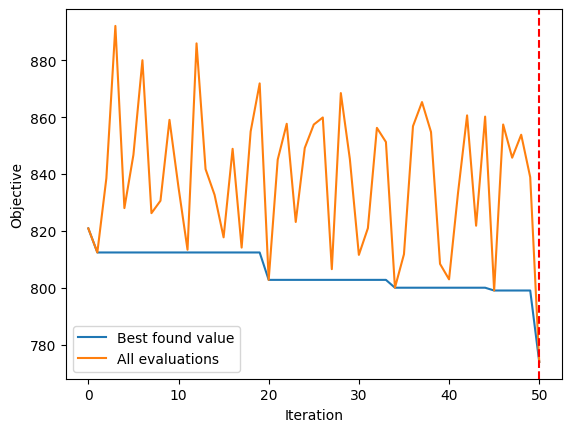

In [10]:
# print trial results
print(f"Best value found: {train_Y.min().item()}")
print(f"Best solution found: {train_X[train_Y.argmin()].numpy()}")
print(f"Best real value found: {train_Y_real.min().item()}")
print(f"Best real solution found: {train_X[train_Y_real.argmin()].numpy()}")
print(f"Total number of evaluations: {train_Y.shape[0]}")

sliding_min = torch.zeros(train_Y.shape[0])
for i in range(train_Y.shape[0]):
    sliding_min[i] = train_Y[:i+1].min().item()
    
plt.plot(sliding_min, label='Best found value')

#plot all evaluations
plt.plot(train_Y.cpu().numpy(), label='All evaluations')
#vline
plt.axvline(x=n_init, color='r', linestyle='--')
#
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.legend()
plt.show()


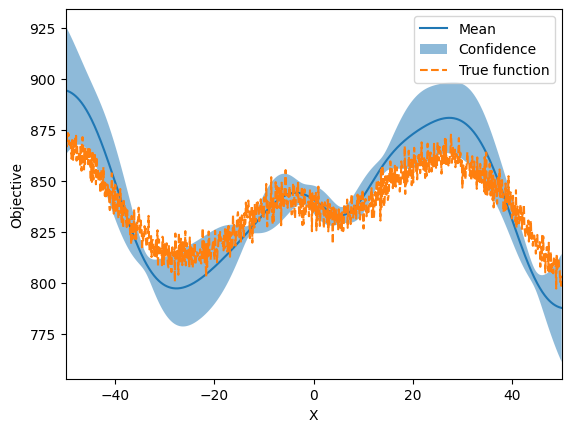

In [11]:


#plot model
X = torch.linspace(bounds[0, 0], bounds[1, 0], 1000, **tkwargs).view(-1, 1)
x = normalize(X, bounds)
with torch.no_grad():
    posterior = model.posterior(x)
    mean = -posterior.mean.detach()
    lower, upper = posterior.mvn.confidence_region()
    lower = -lower
    upper = -upper

plt.plot(X.cpu().numpy(), mean.cpu().numpy(), label='Mean')
plt.fill_between(X.cpu().numpy().flatten(), lower.cpu().numpy().flatten(), upper.cpu().numpy().flatten(), alpha=0.5, label='Confidence')

#plot true function
Y = torch.tensor(problem.y(X.cpu().numpy()))
plt.plot(X.cpu().numpy(), Y.cpu().numpy(), label='True function', linestyle='--')


# Convert your data to numpy arrays for easier manipulation
train_X_np = train_X.cpu().numpy()
train_Y_np = train_Y.cpu().numpy()

# Generate a list of indices for the optimization samples
c_unnormed = list(range(len(train_X_np[n_init:])))

# Normalize the colors to be between 0 and 1

# Plot initial samples
# plt.scatter(train_X_np[:n_init], train_Y_np[:n_init], label='Initial samples', linestyle='None', color='blue', alpha=0.5)

# Plot optimization samples with colors
# plt.scatter(train_X_np[n_init:], train_Y_np[n_init:], label='Optimization samples', linestyle='None', cmap='viridis', alpha=0.5, marker='x')

plt.xlabel('X')
plt.xlim(bounds[0, 0], bounds[1, 0])
plt.ylabel('Objective')
plt.legend()
plt.show()
